In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import re
import os
from dotenv import load_dotenv
load_dotenv()

True

In [22]:
RESEARCH_TOPIC = 'Multimodal Sentiment Analysis' # Change this to the research topic you are interested in
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY") # Set your OpenAI API key as an environment variable

The dataset is collected from Scopus website using the export function.

The searching criteria is "Title-Abstract-Keywords: Multimodal AND Sentiment AND Analysis".

To prepare your own dataset, the necessary columns are "Title", "Abstract", and "Keywords".

In [9]:
papers = pd.read_csv('papers_data.csv')

print(f'Columns in the dataset: {papers.columns}')
print(f'Number of papers: {len(papers)}')
print(papers.describe())
papers.head()

Columns in the dataset: Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author Keywords',
       'Index Keywords', 'Molecular Sequence Numbers', 'Chemicals/CAS',
       'Tradenames', 'Manufacturers', 'Funding Details', 'Funding Texts',
       'References', 'Correspondence Address', 'Editors', 'Publisher',
       'Sponsors', 'Conference name', 'Conference date', 'Conference location',
       'Conference code', 'ISSN', 'ISBN', 'CODEN', 'PubMed ID',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')
Number of papers: 1883
              Year    Page count     Cited by  Molecular Sequence Numbers  \
count  1883.000000   1341.000000  1883.000000                   

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,ISBN,CODEN,PubMed ID,Language of Original Document,Abbreviated Source Title,Document Type,Publication Stage,Open Access,Source,EID
0,Zou W.; Sun X.; Lu Q.; Wang X.; Feng J.,"Zou, Wang (58497825600); Sun, Xia (56341695200...",58497825600; 56341695200; 57216037356; 5938823...,A vision and language hierarchical alignment f...,2025,Pattern Recognition,162,NaN,111369,NaN,...,NaN,PTNRA,NaN,English,Pattern Recogn.,Article,Final,NaN,Scopus,2-s2.0-85215442699
1,Wang H.; Du Q.; Xiang Y.,"Wang, Hongbing (59560002000); Du, Qifei (59560...",59560002000; 59560407900; 55836565000,Image–text sentiment analysis based on hierarc...,2025,Engineering Applications of Artificial Intelli...,146,NaN,110262,NaN,...,NaN,EAAIE,NaN,English,Eng Appl Artif Intell,Article,Final,NaN,Scopus,2-s2.0-85217967973
2,Zhang D.,"Zhang, Dingkai (57215547438)",57215547438,Pffm-se: a passenger flow forecasting model fo...,2025,Transportation,NaN,NaN,100122,NaN,...,NaN,NaN,NaN,English,Transportation,Article,Article in press,NaN,Scopus,2-s2.0-85218145146
3,Yang Z.; He Q.; Du N.; He Q.,"Yang, Zhihao (59503587400); He, Qing (57189500...",59503587400; 57189500080; 57222383453; 5897855...,Temporal text-guided feedback-based progressiv...,2025,Alexandria Engineering Journal,116,NaN,NaN,699,...,NaN,NaN,NaN,English,Alexandria Engineering Journal,Article,Final,NaN,Scopus,2-s2.0-85214321812
4,Xiu T.; Gao Y.; Sun Y.; Wu J.; Zhang X.; Zhang...,"Xiu, Taiyu (59559510300); Gao, Yunting (595603...",59559510300; 59560311300; 59560111200; 5955910...,The Analysis of Emotion-Aware Personalized Rec...,2025,Journal of Organizational and End User Computing,37,1,NaN,NaN,...,NaN,NaN,NaN,English,J. Organ. End User Comput.,Article,Final,NaN,Scopus,2-s2.0-85217951146


Data Cleaning and Preprocessing

In [12]:
print("Missing values in each column:")
print(papers.isnull().sum())

# Drop columns where the proportion of missing values is greater than 30%
papers = papers.loc[:, papers.isnull().mean() <= 0.2]

Missing values in each column:
Authors                           206
Author full names                 206
Author(s) ID                      206
Title                               0
Year                                0
Source title                        0
Volume                            708
Issue                            1375
Art. No.                         1463
Page start                        729
Page end                          734
Page count                        542
Cited by                            0
DOI                               345
Link                                0
Affiliations                      208
Authors with affiliations         208
Abstract                            0
Author Keywords                   425
Index Keywords                    414
Molecular Sequence Numbers       1883
Chemicals/CAS                    1882
Tradenames                       1881
Manufacturers                    1881
Funding Details                  1037
Funding Texts      

In [13]:
# Remove DOI column as not necessary for analysis
papers = papers.drop(columns=['DOI'])
papers.dropna(inplace=True)
len(papers)


1650

### Extract country of affiliation

In [14]:
def country_from_affiliation(affiliation):
    # Split the string by comma and extract the last element
    match = re.search(r'(\b\w+\b)\s*;', affiliation)
    if match:
        return match.group(1)
    else:
        # If no semicolon is found, return the last word in the text.
        words = re.findall(r'\b\w+\b', text)
        return words[-1] if words else None


text = "Faculty of Information Engineering and Automation, Kunming University of Science and Technology, Yunnan, Kunming, 650500, China; School of Computer Science and Technology, Yunnan University, Yunnan, Kunming, 650091, China"
print(country_from_affiliation(text))
papers['Country'] = papers['Affiliations'].apply(country_from_affiliation)

China


### Extract institutions from affiliations

In [15]:
def get_main_insitution(affiliation):
    # 1) Take only the first chunk (in case there are multiple separated by semicolons).
    first_chunk = affiliation.split(';')[0].strip()

    keywords = [
        'University', 'College', 'School', 'Institute', 'Academy',
        'Laboratory', 'Lab', 'Center', 'Centre'
    ]

    # 3) Build a regex pattern to capture a phrase that includes at least one of the keywords.
    #    - Starts with a capital word (e.g., "London" or "Faculty")
    #    - Possibly followed by more words or connectors (of / and / in / for / etc.)
    #    - Ends in one of the keywords, and can continue with "of ...", "and ...", etc.
    #
    #    Example match: "London School of Economics and Political Science"
    #    Example match: "Kunming University of Science and Technology"
    #
    #    Explanation:
    #    - [A-Z][a-zA-Z&.\'-]+ : A capital letter followed by letters, &, ., ', or - (a naive "word" with possible punctuation)
    #    - (?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))* : zero or more groups of spaces plus either "of/and/in/for" or another capitalized word
    #    - (?:University|College|School|Institute|Academy|Laboratory|Lab|Center|Centre) : the institution keyword
    #    - (?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))* : optionally more words/connectors after the keyword
    #
    pattern_str = (
        r'([A-Z][a-zA-Z&.\'-]+'
        r'(?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))*\s+'
        r'(?:' + '|'.join(keywords) + r')'
        r'(?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))*)'
    )
    pattern = re.compile(pattern_str)
    
    # 4) Search in the first chunk
    match = pattern.search(first_chunk)
    if match:
        # Return the matched institution phrase
        return match.group(1).strip()
    else:
        # Fallback: if no match, return the entire first chunk
        return first_chunk
    
text = "School of Computer Science, Monash University, Melbourne, VIC 3800, Australia"
print(get_main_insitution(text))
papers['Institution'] = papers['Affiliations'].apply(get_main_insitution)

Monash University


### Extract first author

In [16]:
def extract_first_author(text):
    # Split the string by comma and extract the first element
    return text.split(';')[0].strip()

papers['First Author'] = papers['Authors'].apply(extract_first_author)

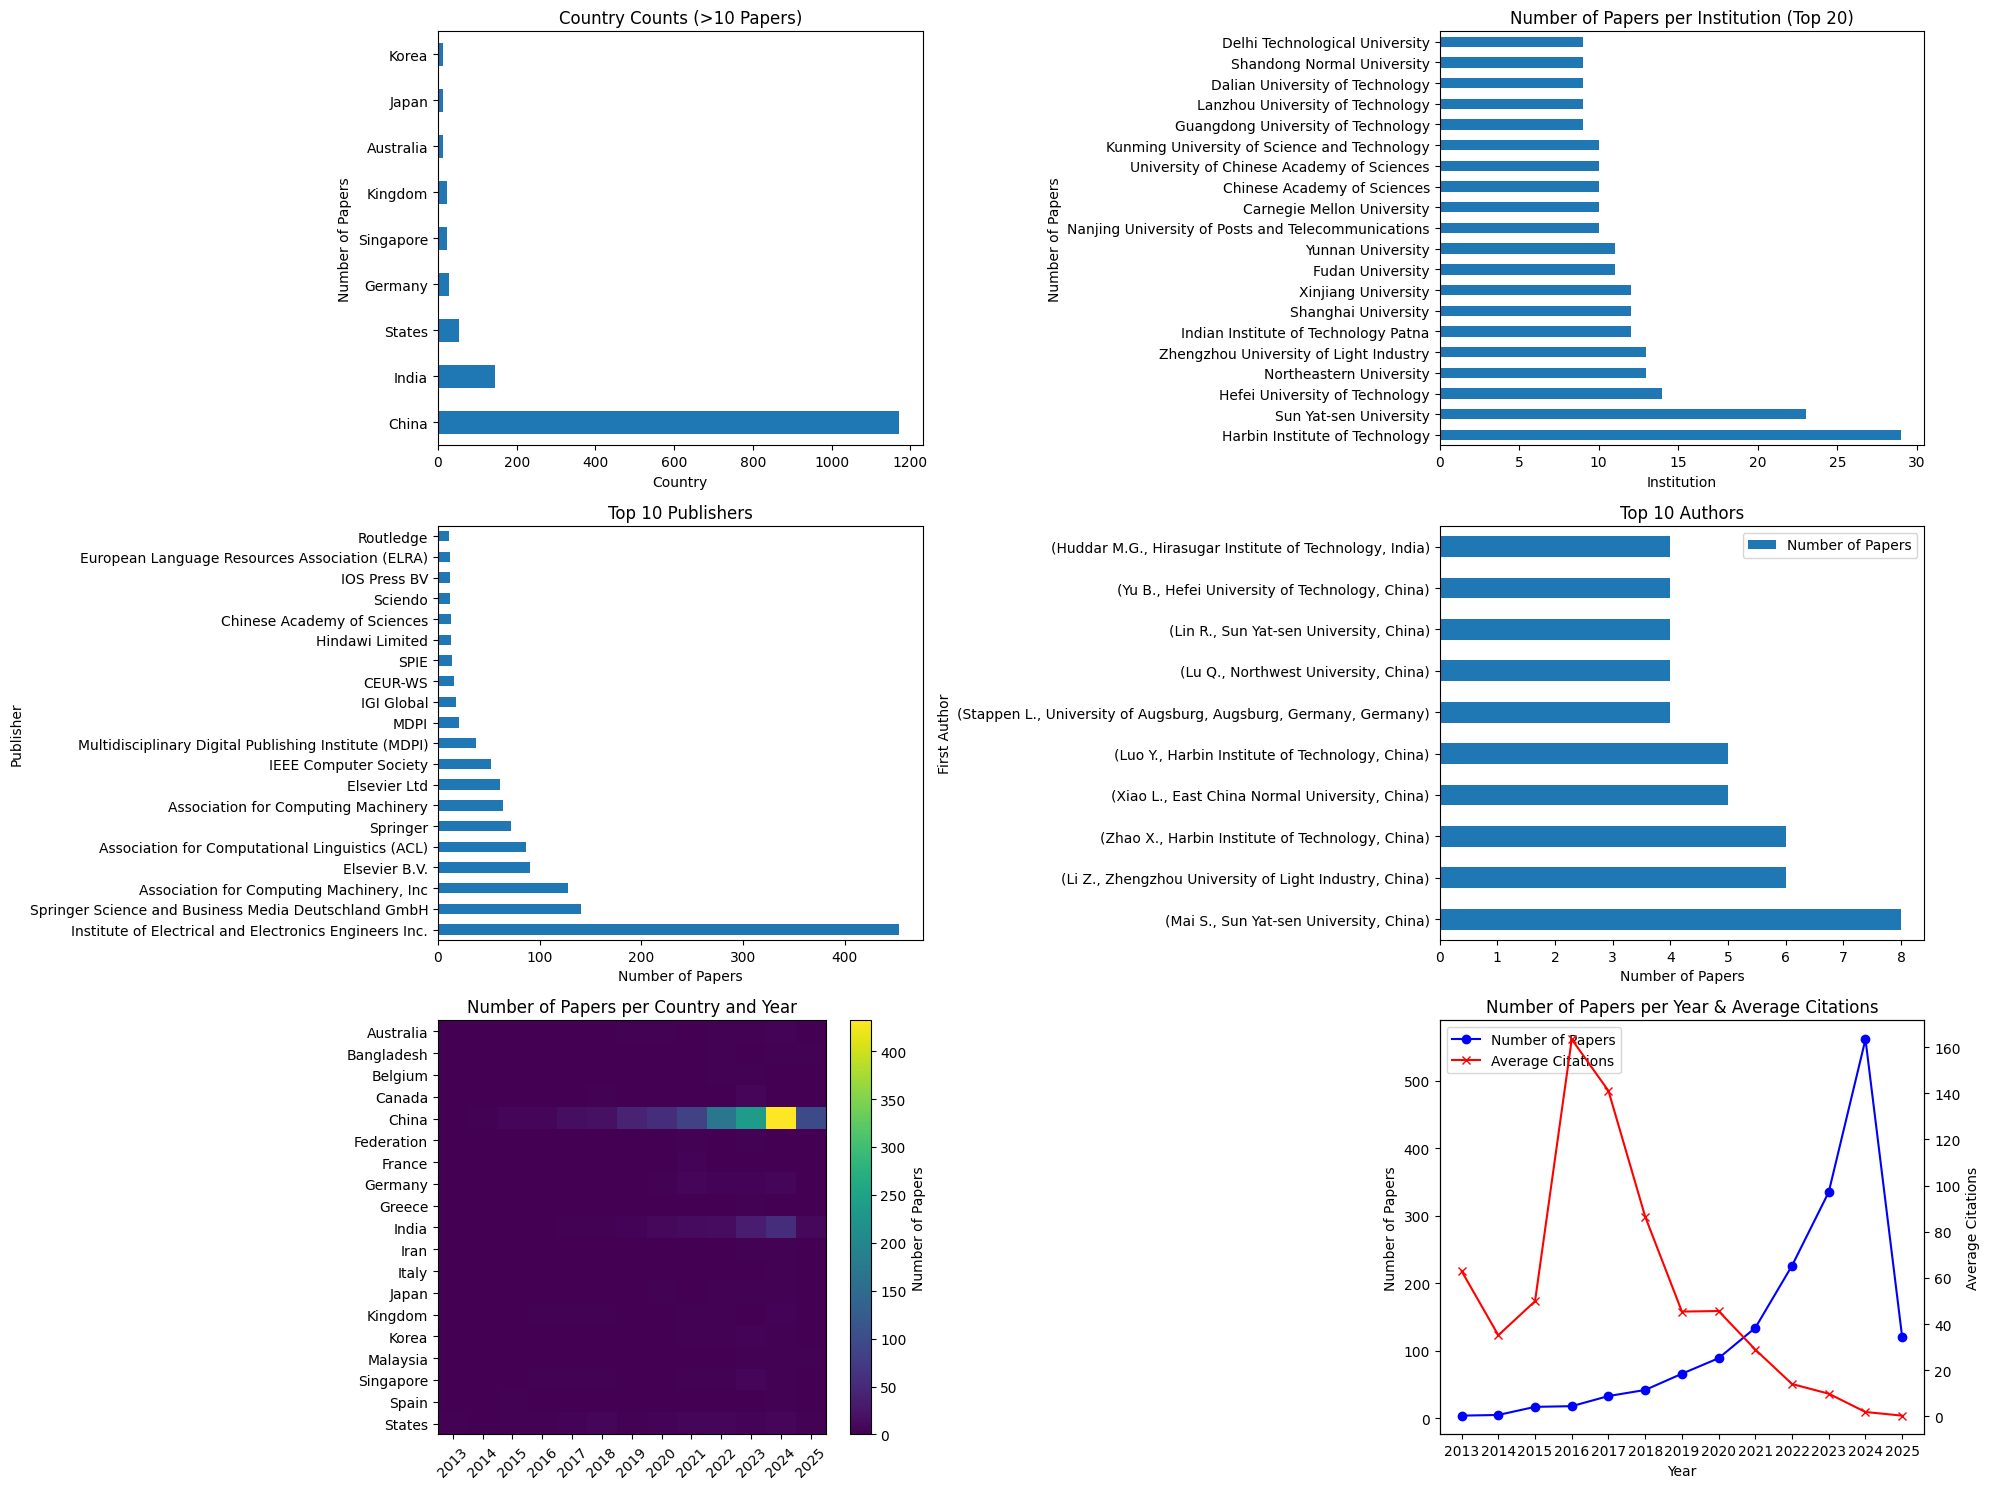

In [17]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
axs = axs.flatten()  # Flatten to simplify indexing

# 1. Plot: Country counts (>10 papers)
country_counts = papers['Country'].value_counts()
country_counts = country_counts[country_counts > 10]
country_counts.plot(kind='barh', ax=axs[0])
axs[0].set_title('Country Counts (>10 Papers)')
axs[0].set_xlabel('Country')
axs[0].set_ylabel('Number of Papers')

# 2. Plot: Institution counts (Top 20)
institution_counts = papers['Institution'].value_counts().sort_values(ascending=False)[:20]
institution_counts.plot(kind='barh', ax=axs[1])
axs[1].set_title('Number of Papers per Institution (Top 20)')
axs[1].set_xlabel('Institution')
axs[1].set_ylabel('Number of Papers')

# 3. Plot: Top 10 Publishers
publisher = papers['Publisher'].value_counts().sort_values(ascending=False)[:20]
publisher.plot(kind='barh', ax=axs[2])
axs[2].set_title('Top 10 Publishers')
axs[2].set_xlabel('Number of Papers')
axs[2].set_ylabel('Publisher')

# 4. Plot: Top 10 Authors (by first author and institution)
author_count = papers.groupby(['First Author', 'Institution', 'Country'])['First Author']\
                     .count().sort_values(ascending=False)[:10]
author_count.plot(kind='barh', ax=axs[3])
axs[3].set_title('Top 10 Authors')
axs[3].set_xlabel('Number of Papers')
axs[3].set_ylabel('First Author')
axs[3].legend(['Number of Papers'])

# 5. Plot: Heatmap of papers per country and year
country_year_counts = papers.groupby(['Country', 'Year']).size().unstack().fillna(0)
country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 5]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
im = axs[4].imshow(country_year_counts, aspect='auto')
axs[4].set_title('Number of Papers per Country and Year')
axs[4].set_yticks(range(len(country_year_counts)))
axs[4].set_yticklabels(country_year_counts.index)
axs[4].set_xticks(range(len(country_year_counts.columns)))
axs[4].set_xticklabels(country_year_counts.columns, rotation=45)
fig.colorbar(im, ax=axs[4], label='Number of Papers')

# 6. Plot: Number of papers per year and average citations
count = papers.groupby('Year').count()
avg_cite = papers.groupby('Year')['Cited by'].mean()
# Plot number of papers on the primary y-axis
count.plot(y='Title', ax=axs[5], label='Number of Papers', color='blue', marker='o')
axs[5].set_title('Number of Papers per Year & Average Citations')
axs[5].set_xticks(count.index)
axs[5].set_xlabel('Year')
axs[5].set_ylabel('Number of Papers')
# Create a secondary y-axis for average citations
ax2 = axs[5].twinx()
avg_cite.plot(ax=ax2, label='Average Citations', color='red', marker='x')
ax2.set_ylabel('Average Citations')
# Combine legends from both axes
lines1, labels1 = axs[5].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[5].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [18]:
aggregated_data = {}

# 1. Country counts (only include countries with more than 10 papers)
aggregated_data['country_paper_counts'] = country_counts.to_dict()

# 2. Institution counts (top 20)
aggregated_data['institution_paper_counts'] = institution_counts.to_dict()

# 3. Publisher counts (top 20)
aggregated_data['publisher_paper_counts'] = publisher.to_dict()

# 4. Top 10 Authors (grouped by First Author, Institution, Country)
aggregated_data['top_authors'] = author_count.to_dict()

# 5. Country-Year counts (for the heatmap)
aggregated_data['country_year_paper_counts'] = country_year_counts.to_dict()

# 6. Papers per year (from the 'Title' count) and average citations per year
aggregated_data['papers_per_year'] = count['Title'].to_dict()
aggregated_data['average_citations_by_year'] = avg_cite.to_dict()

In [23]:
import json
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

prompt_template = """
Below is a JSON summary of publication data related to {RESEARCH_TOPIC}:

{aggregated_data}

Please provide a detailed analysis of this data, focusing on:
1) Which countries have the most publications?
2) Which institutions are most active?
3) Which publishers appear most often?
4) How have citations changed over the years?
5) Any notable trends you see in this dataset.
"""

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["aggregated_data", "RESEARCH_TOPIC"]
)

llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",  # choose a model you prefer
    temperature=0.5,
)

chain = prompt | llm

aggregated_data_json = json.dumps(str(aggregated_data), indent=2)
response = chain.invoke({
    "aggregated_data": aggregated_data_json, 
    "RESEARCH_TOPIC": RESEARCH_TOPIC
})


print("Analysis from OpenAI:\n")
print(response.content)

Analysis from OpenAI:

1) The countries with the most publications in Multimodal Sentiment Analysis are China with 1172 papers, India with 146 papers, and the United States with 53 papers.

2) The most active institutions in producing research on Multimodal Sentiment Analysis include Harbin Institute of Technology with 29 papers, Sun Yat-sen University with 23 papers, and Hefei University of Technology with 14 papers.

3) The most common publishers for research on Multimodal Sentiment Analysis are the Institute of Electrical and Electronics Engineers Inc. with 454 papers, Springer Science and Business Media Deutschland GmbH with 141 papers, and the Association for Computing Machinery, Inc with 128 papers.

4) Citations have varied over the years, with the average number of citations per paper decreasing from 63 in 2013 to 0.37 in 2025. There is a notable peak in citations in 2016 with an average of 163.39 citations per paper.

5) Notable trends in the dataset include a significant incr

### Now we will create embeddings for the papers' abstracts, title and keyword using an embedding model on hugging face
#### I have chosen to use https://huggingface.co/Qdrant/all_miniLM_L6_v2_with_attentions here. You can choose any other model from hugging face as per your requirement. I have chosen this to keep the model size small.


In [33]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\yingq\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yingq\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [35]:
# Combine the title and abstract into a single text for each paper
import torch
papers['text_for_embedding'] = "passage: " + papers['Title'] + ". " + papers['Abstract']
texts = papers['text_for_embedding'].tolist()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
embeddings = model.encode(texts, normalize_embeddings=True)

### Simple Hyperparameter Tuning

In [52]:
from sklearn.metrics import silhouette_score


def tune_agglo_params(embeddings, threshold, n_clusters):
    results = []
    for t in threshold:
        agglo = AgglomerativeClustering(distance_threshold=t, n_clusters=None)
        clusters = agglo.fit_predict(embeddings)
        results.append({
            'threshold': t,
            'n_clusters': len(set(clusters)),
            'silhouette_score': silhouette_score(embeddings, clusters)
        })

    for c in n_clusters:
        agglo = AgglomerativeClustering( n_clusters=c)
        clusters = agglo.fit_predict(embeddings)
        results.append({
            'threshold': None,
            'n_clusters': c,
            'silhouette_score': silhouette_score(embeddings, clusters)
        })
    return pd.DataFrame(results)

threshold = [1, 2, 3, 4, 5]
n_clusters = [5, 10, 15, 20, 25]
params_df = tune_agglo_params(embeddings, threshold, n_clusters)
print(params_df)

   threshold  n_clusters  silhouette_score
0        1.0         366          0.064960
1        2.0          42          0.017926
2        3.0          17          0.021265
3        4.0           8          0.008302
4        5.0           5          0.008880
5        NaN           5          0.008880
6        NaN          10          0.014573
7        NaN          15          0.023218
8        NaN          20          0.013444
9        NaN          25          0.020700


### To balance the number of clusters and the silhouette score, we can choose the parameters that give a good number of clusters with a high silhouette score which is 15 clusters here

In [53]:
# Apply AgglomerativeClustering for clustering
from sklearn.cluster import AgglomerativeClustering


agglo = AgglomerativeClustering(distance_threshold= None, n_clusters=15) 
clusters = agglo.fit_predict(embeddings)

papers['cluster'] = clusters


cluster_to_topic = {-1: "Noise/Outliers"}
for cluster_id in set(clusters):
    if cluster_id != -1:
        cluster_to_topic[cluster_id] = f"Topic {cluster_id + 1}"

# Add topic names to the DataFrame
papers['topic'] = papers['cluster'].map(cluster_to_topic)
papers.groupby('cluster').size()

cluster
0     327
1      71
2      84
3     175
4     502
5     125
6      51
7      89
8     119
9      13
10     24
11     76
12    145
13     12
14     70
dtype: int64